# INF1002 Programming Fundamentals Python Project: HDB Haven Resale Price Prediction

This AI is made by:  
Name: Ng Jing Xiang Edson  
Student ID: 2400677  
Group: LAB-P8 - Group 9  

## Table of Content:
1. [Introduction](#1.-Introduction)  
   1.1 [Import Libraries](#1.1-Import-Libraries)  
   1.2 [Data Collection](#1.2-Data-Collection)  
   1.3 [Data Preprocessing](#1.3-Data-Preprocessing)
2. [Preparing for Model Training](#2.-Preparing-for-Model-Training)  
   2.1 [Load dataset in chunks and Gather unique values from Categorical Columns](#2.1-Load-dataset-in-chunks-and-Gather-unique-values-from-Categorical-Columns)  
   2.2 [Creating Label Encoders for Categorical Columns](#2.2-Creating-Label-Encoders-for-Categorical-Columns)  
   2.3 [Process the Dataset using the Label Encoders](#2.3-Process-the-Dataset-using-the-Label-Encoders)  
   2.4 [Concatenating All chunks and Saving the Label Encoders](#2.4-Concatenating-All-chunks-and-Saving-the-Label-Encoders)  
   2.5 [Scaling the Features and Target](#2.5-Scaling-the-Features-and-Target)  
   2.6 [Splitting the Data](#2.6-Splitting-the-Data)  
3. [Model Training](#3.-Model-Training)  
   3.1 [Decision Tree Regressor](#3.1-Decision-Tree-Regressor)  
   3.2 [Histogram-based Gradient Boosting Regression Tree](#3.2-Histogram-based-Gradient-Boosting-Regression-Tree)  
   3.3 [Random Forest Regressor](#3.3-Random-Forest-Regressor)  
   3.4 [XGBoost Regressor](#3.4-XGBoost-Regressor)  
   3.5 [LSTM Model](#3.5-LSTM-Model)  
   3.6 [Neural Network Model](#3.6-Neural-Network-Model)

## 1. Introduction

This feature's job is to allow the public assess the future resale HDB(Housing and Development Board) flat prices. This is to allow prospective buyers and sellers to make better decisions when they have data-driven forecasts, helping them assess market trends and determine when to buy or sell. Individuals can plan their finances better, whether they are first-time homebuyers, investors, or existing homeowners. Knowing potential future prices can help them strategize and manage long-term investments.

# 1.1 Import Libraries

In [62]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import joblib
from datetime import datetime
import h5py
from tqdm import tqdm
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, ParameterGrid, GroupShuffleSplit, train_test_split
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Activation, Add, Input, LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import model_to_dot, plot_model
from IPython.display import SVG, display

## 1.2 Data Collection

Data used are downloaded from data.gov.sg and kaggle.com  
For data.gov.sg, I used 2 different datasets:  
1. [Resale Flat Prices (By Housing and Development Board)](https://data.gov.sg/datasets?topics=housing&page=1&resultId=189)  
- Consists of HDB resale transaction details since 1990  
- Informations such as Year & Month of transaction, Town, Block Number, Types of Flat, Flat Models, Resale Price, etc.  
2. [HDB Property Information (By Housing and Development Board)](https://data.gov.sg/datasets/d_17f5382f26140b1fdae0ba2ef6239d2f/view)  
- Includes extra details of each HDB flats such as Maximum Floor Level, Year Completed, Block Number, Multi-storey Carpark Tag, etc.

And for kaggle.com, I used 1 dataset:  
1. [HDB Resale Prices with MRT Details, 1990 to Now (By ChngyuanlongRandy)](https://www.kaggle.com/datasets/chngyuanlongrandy/hdb-prices-with-closest-mrt-distance/data)  
- Addition to the details provided by HDB's dataset that includes coordinates of each address and the distance in meters to the nearest MRT station.

================================= CODING STARTS =================================

++++++++++++++++++++++++++++++++++  
Get to current path  
++++++++++++++++++++++++++++++++++

In [154]:
path = os.getcwd()
print(path)

C:\Users\edson\SIT\PF-Project


++++++++++++++++++++++++++++++++++  
Retrieving all CSV files collected  
++++++++++++++++++++++++++++++++++

In [155]:
RFP1990 = pd.read_csv('ResaleFlatPrices_1990-1999.csv')
RFP2000 = pd.read_csv('ResaleFlatPrices_2000-Feb2012.csv')
RFP2012 = pd.read_csv('ResaleFlatPrices_Mar2012-Dec2014.csv')
RFP2015 = pd.read_csv('ResaleFlatPrices_Jan2015-Dec2016.csv')
RFP2017 = pd.read_csv('ResaleFlatPrices_Jan2017onwards.csv')
HDBinfo_df = pd.read_csv('HDBPropertyInformation.csv', low_memory=False)
HDBmrt_df = pd.read_csv('hdb_latest.csv', low_memory=False)

++++++++++++++++++++++++++++++++++  
Compiling RFP1990 - RFP 2017  
++++++++++++++++++++++++++++++++++

In [156]:
file_list = glob.glob(path + "/ResaleFlatPrices*.csv")
print('File names:', file_list)

File names: ['C:\\Users\\edson\\SIT\\PF-Project\\ResaleFlatPrices_1990-1999.csv', 'C:\\Users\\edson\\SIT\\PF-Project\\ResaleFlatPrices_2000-Feb2012.csv', 'C:\\Users\\edson\\SIT\\PF-Project\\ResaleFlatPrices_Jan2015-Dec2016.csv', 'C:\\Users\\edson\\SIT\\PF-Project\\ResaleFlatPrices_Jan2017onwards.csv', 'C:\\Users\\edson\\SIT\\PF-Project\\ResaleFlatPrices_Mar2012-Dec2014.csv']


In [157]:
pd.concat(map(lambda file: pd.read_csv(file, low_memory=False), file_list), ignore_index=True).to_csv(path + "/ResaleFlatPrices_Compiled.csv", index=False)

++++++++++++++++++++++++++++++++++  
Displaying the compiled file that consists of transactions from 1990 to now  
Currently, there are about 936,000 rows of data after compilation  
++++++++++++++++++++++++++++++++++

In [158]:
compiled_df = pd.read_csv('ResaleFlatPrices_Compiled.csv', low_memory=False)
compiled_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0


In [159]:
compiled_df.describe()

,floor_area_sqm,lease_commence_date,resale_price
count,935886.000000,935886.000000,9.358860e+05
mean,95.687866,1988.367216,3.235395e+05
std,25.810764,10.754641,1.730474e+05
min,28.000000,1966.000000,5.000000e+03
25%,73.000000,1981.000000,1.950000e+05
50%,93.000000,1986.000000,3.000000e+05
75%,113.000000,1996.000000,4.200000e+05
max,366.700000,2020.000000,1.588000e+06


++++++++++++++++++++++++++++++++++  
Take a look at other csv files:  
++++++++++++++++++++++++++++++++++

In [160]:
HDBinfo_df.head()

,blk_no,street,max_floor_lvl,year_completed,residential,commercial,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,...,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental
0,1,BEACH RD,16,1970,Y,Y,N,N,N,N,...,138,1,2,0,0,0,0,0,0,0
1,1,BEDOK STH AVE 1,14,1975,Y,N,N,Y,N,N,...,204,0,2,0,0,0,0,0,0,0
2,1,CANTONMENT RD,2,2010,N,Y,N,N,N,N,...,0,0,0,0,0,0,0,0,0,0
3,1,CHAI CHEE RD,15,1982,Y,N,N,N,N,N,...,0,10,92,0,0,0,0,0,0,0
4,1,CHANGI VILLAGE RD,4,1975,Y,Y,N,N,N,N,...,54,0,1,0,0,0,0,0,0,0


In [161]:
HDBmrt_df.head()

,Unnamed: 0,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,block,remaining_lease,address,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt
0,0,ANG MO KIO,3 ROOM,Improved,69.0,ANG MO KIO AVE 4,147000.0,2000-01,1986,07 TO 09,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
1,1,ANG MO KIO,3 ROOM,Improved,60.0,ANG MO KIO AVE 4,130000.0,2000-02,1986,07 TO 09,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
2,2,ANG MO KIO,2 ROOM,Improved,45.0,ANG MO KIO AVE 4,105000.0,2000-03,1986,04 TO 06,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
3,3,ANG MO KIO,2 ROOM,Improved,45.0,ANG MO KIO AVE 4,125000.0,2000-05,1986,04 TO 06,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
4,4,ANG MO KIO,2 ROOM,Improved,45.0,ANG MO KIO AVE 4,117000.0,2000-06,1986,07 TO 09,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283


++++++++++++++++++++++++++++++++++  
To compile the other csv, I filter out the columns I want from the csv after renaming, then merged with the main file.  
++++++++++++++++++++++++++++++++++

In [162]:
HDBinfo_df.rename(columns={'blk_no': 'block', 'street': 'street_name'}, inplace=True)

In [163]:
HDBinfo_df = HDBinfo_df[['block', 'street_name', 'max_floor_lvl', 'year_completed']]
HDBinfo_df.head()

,block,street_name,max_floor_lvl,year_completed
0,1,BEACH RD,16,1970
1,1,BEDOK STH AVE 1,14,1975
2,1,CANTONMENT RD,2,2010
3,1,CHAI CHEE RD,15,1982
4,1,CHANGI VILLAGE RD,4,1975


In [164]:
compiled_df = pd.merge(compiled_df, HDBinfo_df, on = ['block','street_name'])

In [165]:
HDBmrt_df = HDBmrt_df[['block', 'street_name', 'nearest_mrt', 'nearest_distance_to_mrt']]
HDBmrt_df = HDBmrt_df.drop_duplicates(subset=['block','street_name'])

In [166]:
compiled_df = pd.merge(compiled_df, HDBmrt_df, on = ['block','street_name'])

++++++++++++++++++++++++++++++++++  
This shows the compiled dataset that includes all the csv files with regards to filtered columns.  
++++++++++++++++++++++++++++++++++

In [167]:
compiled_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,max_floor_lvl,year_completed,nearest_mrt,nearest_distance_to_mrt
0,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,10,1975,mayflower,0.803
1,1990-01,ANG MO KIO,3 ROOM,211,ANG MO KIO AVE 3,01 TO 03,67.0,NEW GENERATION,1977,46000.0,10,1976,mayflower,0.620
2,1990-01,ANG MO KIO,3 ROOM,202,ANG MO KIO AVE 3,07 TO 09,67.0,NEW GENERATION,1977,42000.0,10,1976,ang mo kio,0.584
3,1990-01,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,10 TO 12,67.0,NEW GENERATION,1977,38000.0,12,1976,mayflower,0.516
4,1990-01,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,04 TO 06,67.0,NEW GENERATION,1977,40000.0,12,1976,mayflower,0.516


## 1.3 Data Preprocessing

Since I am working with multipl csv files, I went though a few processes to make sure the data are combined and cleaned. With addition of variables and removal of redundant columns, as well as checking for NaN values to ensure data are set for further preprocessing. I also chunked, label encoded and normalize the data to fit into the model. Afterwards, I split the data to get it ready for training.

================================= CODING STARTS =================================

++++++++++++++++++++++++++++++++++  
Now, I need to find out which columns I do not need from the dataset as well as adding new columns that may help with the model finding relationships between each variable.  
++++++++++++++++++++++++++++++++++  

++++++++++++++++++++++++++++++++++  
Because of the the difference between HDB naming system, I have decided to drop the column. According to the [article (By Teoalida)](https://www.teoalida.com/singapore/hdbflattypes/comment-page-2/), since 1998, ALL 4-room are Model A and all 5-Room are Improved. This creates confusion with the 1970s Improved and 1980s Model A flats, also the today 5-Room flats are nothing else than a larger 4-Room, being the smallest flats named 5-Room in HDB history.  
++++++++++++++++++++++++++++++++++  

In [168]:
# View all different flat models to assign a value
compiled_df['flat_model'].unique()

array(['NEW GENERATION', 'IMPROVED', 'MODEL A', 'STANDARD', 'SIMPLIFIED',
       'MODEL A-MAISONETTE', 'APARTMENT', 'MAISONETTE', 'TERRACE',
       '2-ROOM', 'IMPROVED-MAISONETTE', 'MULTI GENERATION',
       'PREMIUM APARTMENT', 'Improved', 'New Generation', 'Model A',
       'Standard', 'Apartment', 'Simplified', 'Model A-Maisonette',
       'Maisonette', 'Multi Generation', 'Adjoined flat',
       'Premium Apartment', 'Terrace', 'Improved-Maisonette',
       'Premium Maisonette', '2-room', 'Model A2', 'Type S1', 'Type S2',
       'DBSS', 'Premium Apartment Loft', '3Gen'], dtype=object)

In [169]:
compiled_df = compiled_df.drop(['flat_model'], axis=1)

++++++++++++++++++++++++++++++++++  
Unfortunately, based on this [article (By Deborah)](https://www.singsaver.com.sg/blog/what-happens-after-99-year-housing-lease), HDB flats will revert back to its original owner once the 99-year lease expires, whether it is to HDB, SLA or other owners, the flat will pratically be worth S$0 and previous owner no longer given the right to continue living in the apartment. This may cause the flats to decrease in value once it is nearing the 99-year mark. I decided to add "remaining_lease" column as I think there should be a comparison between a old house and a new house, where a 10 year-old house would typically cost more than a 70 year-old house.  
++++++++++++++++++++++++++++++++++

In [170]:
compiled_df["remaining_lease"] = 99 - (datetime.now().year - compiled_df["lease_commence_date"])
compiled_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,lease_commence_date,resale_price,max_floor_lvl,year_completed,nearest_mrt,nearest_distance_to_mrt,remaining_lease
0,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,1976,47200.0,10,1975,mayflower,0.803,51
1,1990-01,ANG MO KIO,3 ROOM,211,ANG MO KIO AVE 3,01 TO 03,67.0,1977,46000.0,10,1976,mayflower,0.620,52
2,1990-01,ANG MO KIO,3 ROOM,202,ANG MO KIO AVE 3,07 TO 09,67.0,1977,42000.0,10,1976,ang mo kio,0.584,52
3,1990-01,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,10 TO 12,67.0,1977,38000.0,12,1976,mayflower,0.516,52
4,1990-01,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,04 TO 06,67.0,1977,40000.0,12,1976,mayflower,0.516,52


++++++++++++++++++++++++++++++++++  
Based on [PropertyGuru Editorial Team (2022)](https://www.propertyguru.com.sg/property-guides/high-floor-vs-low-floor-unit-which-is-better-45449), high-floor or low-floor unit is a huge deciding factor as the different floor level have their own perks. Therefore prices may vary between each level and PropertyGuru uses Low, Medium and High in each flat sales to allow homebuyers to decide which suits their needs. Since the model will not be able to understand the hierarchical value of X to Y, I decided to arrange them as 1 (low floor), 2 (medium floor), 3 (high floor) with association with 'max-floor' for each building/block.  
++++++++++++++++++++++++++++++++++

In [171]:
compiled_df["storey_range"].sort_values().unique()

array(['01 TO 03', '01 TO 05', '04 TO 06', '06 TO 10', '07 TO 09',
       '10 TO 12', '11 TO 15', '13 TO 15', '16 TO 18', '16 TO 20',
       '19 TO 21', '21 TO 25', '22 TO 24', '25 TO 27', '26 TO 30',
       '28 TO 30', '31 TO 33', '31 TO 35', '34 TO 36', '36 TO 40',
       '37 TO 39', '40 TO 42', '43 TO 45', '46 TO 48', '49 TO 51'],
      dtype=object)

In [172]:
def categorize_storey(row):
    max_floor = row['max_floor_lvl']
    storey_range = row['storey_range']

    if max_floor <= 10:
        if storey_range in ["01 TO 03", "01 TO 05"]:
            return 1
        elif storey_range in ["04 TO 06"]:
            return 2
        elif storey_range in ["06 TO 10", "07 TO 09", "10 TO 12", 4]:
            return 3
    elif 11 <= max_floor <= 20:
        if storey_range in ["01 TO 03", "01 TO 05", "04 TO 06"]:
            return 1
        elif storey_range in ["06 TO 10", "07 TO 09", "10 TO 12", "11 TO 15", "13 TO 15"]:
            return 2
        elif storey_range in ["16 TO 18", "16 TO 20", "19 TO 21"]:
            return 3
    elif 21 <= max_floor <= 30:
        if storey_range in ["01 TO 03", "01 TO 05", "04 TO 06", "06 TO 10", "07 TO 09"]:
            return 1
        elif storey_range in ["10 TO 12", "11 TO 15", "13 TO 15", "16 TO 18", "16 TO 20", "19 TO 21"]:
            return 2
        elif storey_range in ["21 TO 25", "22 TO 24", "25 TO 27", "26 TO 30", "28 TO 30"]:
            return 3
    elif 31 <= max_floor <= 40:
        if storey_range in ["01 TO 03", "01 TO 05", "04 TO 06", "06 TO 10", "07 TO 09", "10 TO 12", "11 TO 15"]:
            return 1
        elif storey_range in ["13 TO 15", "16 TO 18", "16 TO 20", "19 TO 21", "21 TO 25", "22 TO 24", "25 TO 27", "26 TO 30"]:
            return 2
        elif storey_range in ["28 TO 30", "31 TO 33", "31 TO 35", "34 TO 36", "36 TO 40", "37 TO 39", "40 TO 42"]:
            return 3
    elif 41 <= max_floor <= 50:
        if storey_range in ["01 TO 03", "01 TO 05", "04 TO 06", "06 TO 10", "07 TO 09", "10 TO 12", "11 TO 15", "13 TO 15"]:
            return 1
        elif storey_range in ["16 TO 18", "16 TO 20", "19 TO 21", "21 TO 25", "22 TO 24", "25 TO 27", "26 TO 30", "28 TO 30", "31 TO 33", "31 TO 35"]:
            return 2
        elif storey_range in ["34 TO 36", "36 TO 40", "37 TO 39", "40 TO 42", "43 TO 45", "46 TO 48", "49 TO 51"]:
            return 3
    return storey_range

compiled_df['storey_range'] = compiled_df.apply(categorize_storey, axis=1)
compiled_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,lease_commence_date,resale_price,max_floor_lvl,year_completed,nearest_mrt,nearest_distance_to_mrt,remaining_lease
0,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,2,73.0,1976,47200.0,10,1975,mayflower,0.803,51
1,1990-01,ANG MO KIO,3 ROOM,211,ANG MO KIO AVE 3,1,67.0,1977,46000.0,10,1976,mayflower,0.620,52
2,1990-01,ANG MO KIO,3 ROOM,202,ANG MO KIO AVE 3,3,67.0,1977,42000.0,10,1976,ang mo kio,0.584,52
3,1990-01,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,2,67.0,1977,38000.0,12,1976,mayflower,0.516,52
4,1990-01,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,1,67.0,1977,40000.0,12,1976,mayflower,0.516,52


++++++++++++++++++++++++++++++++++  
However, some rows does not have a max floor corresponding to the address, therefore they will be invalid rows of data. I decided to drop them and left with 918,249 rows of data.  
++++++++++++++++++++++++++++++++++  

In [173]:
compiled_df = compiled_df.drop(compiled_df[(compiled_df.storey_range == "16 TO 18") | (compiled_df.storey_range == "13 TO 15")].index)
compiled_df.describe()

,floor_area_sqm,lease_commence_date,resale_price,max_floor_lvl,year_completed,nearest_distance_to_mrt,remaining_lease
count,918249.000000,918249.000000,9.182490e+05,918249.000000,918249.000000,918249.000000,918249.000000
mean,96.258895,1988.488218,3.257941e+05,13.913009,1987.105263,0.648826,63.488218
std,25.605425,10.574689,1.715982e+05,5.118506,10.714383,0.375262,10.574689
min,31.000000,1966.000000,5.000000e+03,1.000000,1949.000000,0.023000,41.000000
25%,73.000000,1981.000000,1.990000e+05,12.000000,1980.000000,0.373000,56.000000
50%,93.000000,1986.000000,3.000000e+05,12.000000,1985.000000,0.585000,61.000000
75%,114.000000,1996.000000,4.200000e+05,16.000000,1994.000000,0.850000,71.000000
max,366.700000,2019.000000,1.588000e+06,50.000000,2019.000000,3.666000,94.000000


++++++++++++++++++++++++++++++++++  
Checking for fields that have null values  
++++++++++++++++++++++++++++++++++  

In [174]:
compiled_df.isnull().sum()

month                      0
town                       0
flat_type                  0
block                      0
street_name                0
storey_range               0
floor_area_sqm             0
lease_commence_date        0
resale_price               0
max_floor_lvl              0
year_completed             0
nearest_mrt                0
nearest_distance_to_mrt    0
remaining_lease            0
dtype: int64

++++++++++++++++++++++++++++++++++  
Converting 'month' column that consist of YYYY-MM into hierarchical numbers. By setting a base year (1960) as Singapore's first HDB being built, I will apply a simple linear transformation that converts a year and month combination into the total number of months since the base year. This will ensure that the converted month will not overlap/duplicate with each other.
++++++++++++++++++++++++++++++++++  

In [175]:
compiled_df['month'] = compiled_df['month'].apply(lambda year_month: (int(year_month.split('-')[0]) - 1960) * 12 + int(year_month.split('-')[1]))

In [176]:
compiled_df['month']

0         361
1         361
2         361
3         361
4         361
         ... 
918324    660
918325    660
918326    660
918327    660
918328    660
Name: month, Length: 918249, dtype: int64

++++++++++++++++++++++++++++++++++  
Rearranging the columns  
++++++++++++++++++++++++++++++++++  

In [177]:
compiled_df = compiled_df[['resale_price', 'month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'lease_commence_date', 'remaining_lease', 'max_floor_lvl', 'year_completed', 'nearest_mrt', 'nearest_distance_to_mrt']]
compiled_df.head()

,resale_price,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,max_floor_lvl,year_completed,nearest_mrt,nearest_distance_to_mrt
0,47200.0,361,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,2,73.0,1976,51,10,1975,mayflower,0.803
1,46000.0,361,ANG MO KIO,3 ROOM,211,ANG MO KIO AVE 3,1,67.0,1977,52,10,1976,mayflower,0.620
2,42000.0,361,ANG MO KIO,3 ROOM,202,ANG MO KIO AVE 3,3,67.0,1977,52,10,1976,ang mo kio,0.584
3,38000.0,361,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,2,67.0,1977,52,12,1976,mayflower,0.516
4,40000.0,361,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,1,67.0,1977,52,12,1976,mayflower,0.516


++++++++++++++++++++++++++++++++++  
Saving the cleaned and compiled csv files into a single csv file.  
++++++++++++++++++++++++++++++++++  

In [178]:
compiled_df.to_csv('ResaleFlatPrices.csv', index=False)

## 2. Preparing for Model Training

I will be preparing the data for machine by chunking, applying label encoding to categorical variables, scaling numerical features and split them into training and testing sets.

++++++++++++++++++++++++++++++++++  
### 2.1 Load dataset in chunks and Gather unique values from Categorical Columns
First, I need to handle the LARGE dataset efficiently by reading the CSV file in manageable chunks of 10,000 rows.  
++++++++++++++++++++++++++++++++++  

In [28]:
# Loading dataset in chunks
file_path = 'ResaleFlatPrices.csv'
chunk_size = 100000

# Initializing lists to collect chunks
X_list = []
y_list = []

# Initializing the dictionary to store label encoders
label_encoders = {}
unique_values_dict = {}

# Gathering unique values first
for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    for col in chunk.columns:
        if chunk[col].dtype == 'object':
            if col not in unique_values_dict:
                unique_values_dict[col] = set()
            unique_values_dict[col].update(chunk[col].unique())

++++++++++++++++++++++++++++++++++  
### 2.2 Creating Label Encoders for Categorical Columns 
Mapping categorical values to numeric values for the model compatibility.  
++++++++++++++++++++++++++++++++++  

In [30]:
for col, unique_values in unique_values_dict.items():
    label_encoders[col] = {value: idx for idx, value in enumerate(unique_values)}

++++++++++++++++++++++++++++++++++  
### 2.3 Process the Dataset using the Label Encoders  
Process each chunk with mapping from 2.1   
++++++++++++++++++++++++++++++++++  

In [31]:
# Creating a unique identifier (flat_id) using a combination of block, street_name and flat_type
for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    # Create unique flat ID
    chunk['flat_id'] = chunk['block'].astype(str) + '_' + chunk['street_name'] + '_' + chunk['flat_type']
    
    # Separate target and features
    y_chunk = chunk['resale_price']
    X_chunk = chunk.drop(columns=['resale_price'])

    # Map categorical columns using the pre-defined label encoders
    for col in X_chunk.columns:
        if col in label_encoders:
            X_chunk[col] = X_chunk[col].map(label_encoders[col]).fillna(-1)

    # Append processed chunk to the lists
    X_list.append(X_chunk)
    y_list.append(y_chunk)
    print(f"Processed a chunk with shape {X_chunk.shape}")

Processed a chunk with shape (100000, 14)
Processed a chunk with shape (100000, 14)
Processed a chunk with shape (100000, 14)
Processed a chunk with shape (100000, 14)
Processed a chunk with shape (100000, 14)
Processed a chunk with shape (100000, 14)
Processed a chunk with shape (100000, 14)
Processed a chunk with shape (100000, 14)
Processed a chunk with shape (100000, 14)
Processed a chunk with shape (18249, 14)


++++++++++++++++++++++++++++++++++  
### 2.4 Concatenating All chunks and Saving the Label Encoders  
After processing each chunk, the processed chunks (X and y) are concatenated into complete dataset. The label encoders are saved for future use such as applying the same encodings to new data.  
++++++++++++++++++++++++++++++++++  

In [32]:
# Concatenate all chunks into a single DataFrame/Series
X = pd.concat(X_list, axis=0).reset_index(drop=True)
y = pd.concat(y_list, axis=0).reset_index(drop=True)

# Check the final shape and dtypes
print(f"Final feature shape: {X.shape}")
print(f"Final target shape: {y.shape}")
print(X.dtypes)

# Save the mappings of label encoders
label_encoders_filename = 'label_encoders.pkl'
joblib.dump(label_encoders, label_encoders_filename)

print("Label encoders saved.")

Final feature shape: (918249, 14)
Final target shape: (918249,)
month                        int64
town                         int64
flat_type                    int64
block                        int64
street_name                  int64
storey_range                 int64
floor_area_sqm             float64
lease_commence_date          int64
remaining_lease              int64
max_floor_lvl                int64
year_completed               int64
nearest_mrt                  int64
nearest_distance_to_mrt    float64
flat_id                     object
dtype: object
Label encoders saved.


++++++++++++++++++++++++++++++++++  
### 2.5 Scaling the Features and Target 
Normalize the numerical data for improved model performance  
++++++++++++++++++++++++++++++++++  

In [34]:
# Initialize scalers
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Normalize the features and target (resale_price)
X_scaled = scaler_X.fit_transform(X.drop(columns=['flat_id']))
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [35]:
# Saving scalers for future use in model deployment
scaler_X_filename = 'C:\\Users\\edson\\SIT\\PF-Project\\scaler_X.pkl'
scaler_y_filename = 'C:\\Users\\edson\\SIT\\PF-Project\\scaler_y.pkl'
joblib.dump(scaler_X, scaler_X_filename)
joblib.dump(scaler_y, scaler_y_filename)
print(f"Scalers saved as {scaler_X_filename} and {scaler_y_filename}")

Scalers saved as C:\Users\edson\SIT\PF-Project\scaler_X.pkl and C:\Users\edson\SIT\PF-Project\scaler_y.pkl


++++++++++++++++++++++++++++++++++  
### 2.6 Splitting the Data 
The data is split into training and test sets using GroupShuffleSplit which ensures that the same flat_id does not appear in both the training and test sets. This is important to prevent data leakage when working with grouped data.
++++++++++++++++++++++++++++++++++  

In [36]:
# Grouped Split using the 'flat_id' column
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
for train_idx, test_idx in gss.split(X_scaled, y_scaled, groups=X['flat_id']):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

X_scaled[0]

array([-1.7972276 , -0.9687314 ,  1.14706012,  1.49800469,  0.81724637,
        0.567848  , -0.9083586 , -1.18095436, -1.18095436, -0.76448315,
       -1.12981491,  0.68827039,  0.41084522])

## 3. Model Training

I will be using a few tuned pre-trained regressor models and fine-tuning a custom Neural Network Model to try and evaluate the performance for each models.

The model evaluation metrics I will be using are:
- <b>R-squared</b>
  - Quantifies the proportion of variance in the resale flat prices that can be explained by the model
  - A higher value indicates that the model does a good job of capturing the relationship between input features (e.g. location, flat type and storey range) and resale prices
- <b>Mean Absolute Error (MAE)</b>
  - Measures the average absolute difference between predicted prices and actual resale prices.
  - Since MAE is expressed in the same units as the target variable (dollars), it is easy to interpret. It provides a clear picture of the average error in predictions which is crucial for assessing how much the model's predictions deviate from actual prices.
- <b>Mean Squared Error (MSE)</b>
  - MSE calculates the average of the squared differences between predicted and actual prices.
  - By squaring the errors, MSE emphasizes larger discrepancies more than smaller ones. This characteristic makes it particularly useful when larger errors are more consequential in real-world pricing scenarios, such as undervaluing or overvaluing a property.
- <b>Root Mean Sqaured Error (RMSE)</b>
  - It is the square root of MSE and gives an error metric in the same units as the predicted values
  - Helps to gauge the typical magnitude of errors in the predictions, making it easier to understand the model's reliability.
- <b>Mean Absolute Percentage Error (MAPE)</b>
  - Expresses prediction accuracy as a percentage of the actual values.
  - It is valuable for comparing model performance across different datasets or scales. It also provides a sense of how significant the errors are relative to the actual prices which is important for assessing the model's robustness in various market conditions.
- <b>Explained Variance Score</b>
  - This score indicates how much of the variance in resale prices is accounted for by the model's predictions
  - Similar to R-squared, it helps evaluate the model's performance in capturing the underlying patterns in the data. A higher explained variance score means that the model is effective in representing the variability in resale flat prices.
- <b>Predicted Price</b>
  - I decided to use an address to predict the resale price in the future. This is to allow me to evaluate the model(s) that is the outlier or might not be suitable for integration into the website.

<table>
    <tr>
        <th>Models</th>
        <th>R-squared</th>
        <th>MAE</th>
        <th>MSE</th>
        <th>RMSE</th>
        <th>MAPE</th>
        <th>Explained Variance Score</th>
        <th>Predicted Price</th>
    </tr>
    <tr>
        <td>Decision Tree</td>
        <td>0.9611</td>
        <td>21399.34</td>
        <td>1156853940.99</td>
        <td>34012.56</td>
        <td>7.01%</td>
        <td>0.9611</td>
        <td>913,977.60</td>
    </tr>
    <tr>
        <td>Histogram-based Gradient Boosting</td>
        <td>0.9805</td>
        <td>16821.56</td>
        <td>581700249.34</td>
        <td>24118.46</td>
        <td>5.89%</td>
        <td>0.9805</td>
        <td>911,627.63</td>
    </tr>
    <tr>
        <td>Random Forest</td>
        <td>0.9202</td>
        <td>33198.49</td>
        <td>2374037645.07</td>
        <td>48724.10</td>
        <td>10.67%</td>
        <td>0.9203</td>
        <td>743,385.70</td>
    </tr>
    <tr>
        <td>XGBoost</td>
        <td>0.9766</td>
        <td>17037.08</td>
        <td>696370148.40</td>
        <td>26388.83</td>
        <td>5.78%</td>
        <td>0.9766</td>
        <td>914,165.94</td>
    </tr>
    <tr>
        <td>LSTM</td>
        <td>0.9639</td>
        <td>23080.89</td>
        <td>1074812222.38</td>
        <td>32784.33</td>
        <td>8.38%</td>
        <td>0.9643</td>
        <td>923,292.25</td>
    </tr>
    <tr>
        <td>Neural Network</td>
        <td>0.8703</td>
        <td>39765.62</td>
        <td>3858987824.95</td>
        <td>62120.75</td>
        <td>12.19%</td>
        <td>0.8718</td>
        <td>640,832.12</td>
    </tr>
</table>


++++++++++++++++++++++++++++++++++  
### 3.1 Decision Tree Regressor 
The reasons I tried Decision tree are:
- Handling Non-linear Relationships
  - Decision Tree can model complex non-linear relationships between the features and target values without needing transformations which is valuable for this dataset as relationships are not linear.
- Robustness to Outliers
  - It is less influenced by outliers than some other regression techniques since they split based on feature thresholds where extreme values have less impact on the predictions.  

++++++++++++++++++++++++++++++++++  

++++++++++++++++++++++++++++++++++  
In my code, I am implementing a process to optimize a Decision Tree Regressor for a regression task. I start by creating an instance of the Decision Tree model and defining a grid of hyperparameters to explore, which includes options for max_depth, min_samples_split, and min_samples_leaf.

Next, I generate all possible combinations of these hyperparameters using ParameterGrid. Then, I loop through each combination, updating the model with the current set of parameters. For each combination, I train the model on the training data, make predictions on the test data, and calculate the Mean Absolute Error (MAE) as a performance metric.

If the MAE for the current model is lower than the previously recorded best score, I update the best model and best score accordingly. Finally, after evaluating all combinations, I save the best-performing model to disk. This approach helps me find the most suitable hyperparameters for my Decision Tree Regressor, improving its predictive performance.  
++++++++++++++++++++++++++++++++++

In [90]:
# Define the model
dt_regressor = DecisionTreeRegressor(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Creating a parameter grid manually
param_list = list(ParameterGrid(param_grid))

# Storing the best model and lowest score
best_model = None
best_score = float('inf')

# Progress bar to track progress
with tqdm(total=len(param_list), desc="Training Progress") as pbar:
    for params in param_list:
        # Update the model with the current set of parameters
        dt_regressor.set_params(**params)
        
        # Train the model
        dt_regressor.fit(X_train, y_train)
        
        # Make predictions
        y_pred = dt_regressor.predict(X_test)
        
        # Calculate Mean Absolute Error (MAE) for this set of parameters
        mae = mean_absolute_error(y_test, y_pred)
        
        # If this model has a lower MAE, update the best model and score
        if mae < best_score:
            best_score = mae
            best_model = dt_regressor
        
        # Update the progress bar
        pbar.update(1)

# Making predictions with the best model
y_best_pred = best_model.predict(X_test)

# Save the best model
model_filename = os.path.join("C:\\Users\\edson\\SIT\\PF-Project", 'decisiontree_model_DT.h5')
joblib.dump(best_model, model_filename)
print(f"Model saved as {model_filename}")

Training Progress: 100%|███████████████████████████████████████████████████████████████| 45/45 [01:38<00:00,  2.18s/it]

Model saved as C:\Users\edson\SIT\PF-Project\decisiontree_model_DT.h5


In [91]:
# Both y_test and predictions are inverse-transformed to their original scale
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_best_pred_actual = scaler_y.inverse_transform(y_best_pred.reshape(-1, 1)).ravel()

# Recalculate the metrics on the inverse-transformed data
mae_best = mean_absolute_error(y_test_actual, y_best_pred_actual)
mse_best = mean_squared_error(y_test_actual, y_best_pred_actual)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test_actual, y_best_pred_actual)
mape_best = np.mean(np.abs((y_test_actual - y_best_pred_actual) / np.clip(y_test_actual, 1e-7, None))) * 100
explained_variance_best = explained_variance_score(y_test_actual, y_best_pred_actual)

# Print model evaluation metrics
print(f"Best Decision Tree Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae_best}")
print(f"Mean Squared Error (MSE): {mse_best}")
print(f"Root Mean Squared Error (RMSE): {rmse_best}")
print(f"R-squared: {r2_best}")
print(f"Adjusted R-squared: {1 - (1 - r2_best) * (len(y_test_actual) - 1) / (len(y_test_actual) - X_test.shape[1] - 1)}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_best:.2f}%")
print(f"Explained Variance Score: {explained_variance_best}")

Best Decision Tree Model Evaluation Metrics:
Mean Absolute Error (MAE): 21399.34029303047
Mean Squared Error (MSE): 1156853940.9855127
Root Mean Squared Error (RMSE): 34012.555637374746
R-squared: 0.9611328877746352
Adjusted R-squared: 0.9611301061878446
Mean Absolute Percentage Error (MAPE): 7.01%
Explained Variance Score: 0.9611330000566661


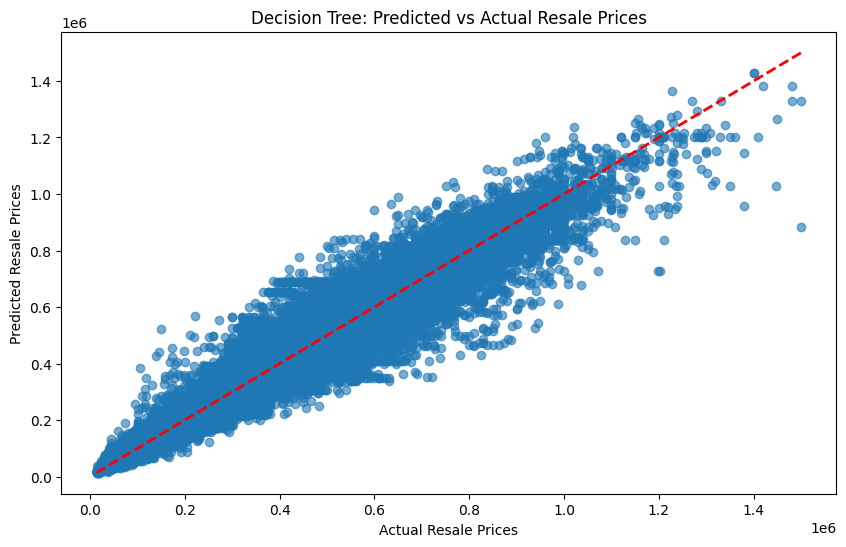

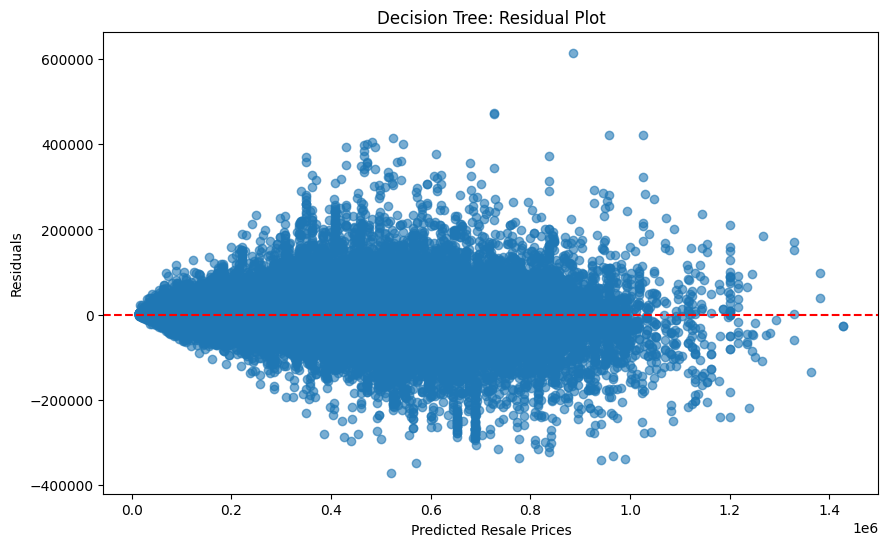

In [92]:
# 1. Plot: Predicted vs Actual Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, y_best_pred_actual, alpha=0.6)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
plt.xlabel('Actual Resale Prices')
plt.ylabel('Predicted Resale Prices')
plt.title('Decision Tree: Predicted vs Actual Resale Prices')
plt.show()

# 2. Plot: Residual Plot (Actual - Predicted)
residuals = y_test_actual - y_best_pred_actual
plt.figure(figsize=(10, 6))
plt.scatter(y_best_pred_actual, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Resale Prices')
plt.ylabel('Residuals')
plt.title('Decision Tree: Residual Plot')
plt.show()

In [93]:
# Load saved Decision Tree model and scalers
model_path = "C:\\Users\\edson\\SIT\\PF-Project\\decisiontree_model_DT.h5"
scaler_X_path = "C:\\Users\\edson\\SIT\\PF-Project\\scaler_X.pkl"
scaler_y_path = "C:\\Users\\edson\\SIT\\PF-Project\\scaler_y.pkl"

# Load the model and scalers
dt_model = joblib.load(model_path)
scaler_X = joblib.load(scaler_X_path)
scaler_y = joblib.load(scaler_y_path)

# Load label encoders
label_encoders = joblib.load('label_encoders.pkl')

# Define input data for prediction
new_flat_values = {
    'month': 837, 
    'town': 'PUNGGOL',
    'flat_type': '5 ROOM', 
    'block': '272A', 
    'street_name': 'PUNGGOL WALK', 
    'storey_range': 3, 
    'floor_area_sqm': 116.0, 
    'lease_commence_date': 2014, 
    'remaining_lease': 89, 
    'max_floor_lvl': 16,  
    'year_completed': 2012,
    'nearest_mrt': 'punggol',
    'nearest_distance_to_mrt': 0.221 
}

# Convert categorical values using the label encoders
for col in new_flat_values:
    if col in label_encoders:
        new_flat_values[col] = label_encoders[col].get(new_flat_values[col], -1)

# Convert to a DataFrame
new_flat_df = pd.DataFrame([new_flat_values])

# Scale the input data
new_flat_scaled = scaler_X.transform(new_flat_df)

# Make the prediction
predicted_price_scaled = dt_model.predict(new_flat_scaled)

# Convert the scaled prediction back to the original price range
predicted_price = scaler_y.inverse_transform(predicted_price_scaled.reshape(-1, 1))

print(f"The predicted resale price is: ${predicted_price[0][0]:,.2f}")

The predicted resale price is: $913,977.60


++++++++++++++++++++++++++++++++++  
### 3.2 Histogram-based Gradient Boosting Regression Tree
The reasons I use this model are:
- Efficiency and Speed
  - It can handle large datasets more efficiently than traditional gradient boosting algorithms. It uses histogram binning which reduces the number of unique values and speeds up both training and prediction.
- Robustness to Overfitting
  - This method incorporates built-in regularization such as the ability to limit tree depth and adjust learning rates which helps prevent overfitting to the training data.

++++++++++++++++++++++++++++++++++  

In [94]:
# Define the model
hgb_regressor = HistGradientBoostingRegressor(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300]
}

# Creating a parameter grid manually
param_list = list(ParameterGrid(param_grid))

# Initialize variables to store the best model and lowest score
best_model = None
best_score = float('inf')

# Progress bar to track progress
with tqdm(total=len(param_list), desc="Training Progress") as pbar:
    for params in param_list:
        # Update the model with the current set of parameters
        hgb_regressor.set_params(**params)
        
        # Train the model using ravel() to ensure y is 1D
        hgb_regressor.fit(X_train, y_train.ravel())
        
        # Make predictions
        y_pred = hgb_regressor.predict(X_test)
        
        # Calculate Mean Absolute Error (MAE) for this set of parameters
        mae = mean_absolute_error(y_test.ravel(), y_pred)
        
        # If this model has a lower MAE, update the best model and score
        if mae < best_score:
            best_score = mae
            best_model = hgb_regressor
        
        # Update the progress bar
        pbar.update(1)

# Make predictions with the best model
y_best_pred = best_model.predict(X_test)

# Save the best model
model_filename = os.path.join("C:\\Users\\edson\\SIT\\PF-Project", 'histgradientboosting_model.h5')
joblib.dump(best_model, model_filename)
print(f"Model saved as {model_filename}")

Training Progress: 100%|█████████████████████████████████████████████████████████████| 135/135 [04:53<00:00,  2.18s/it]


Model saved as C:\Users\edson\SIT\PF-Project\histgradientboosting_model.h5


In [95]:
# Ensure that both y_test and predictions are inverse-transformed to their original scale
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_best_pred_actual = scaler_y.inverse_transform(y_best_pred.reshape(-1, 1)).ravel()

# Recalculate the metrics on the inverse-transformed data
mae_best = mean_absolute_error(y_test_actual, y_best_pred_actual)
mse_best = mean_squared_error(y_test_actual, y_best_pred_actual)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test_actual, y_best_pred_actual)
mape_best = np.mean(np.abs((y_test_actual - y_best_pred_actual) / np.clip(y_test_actual, 1e-7, None))) * 100
explained_variance_best = explained_variance_score(y_test_actual, y_best_pred_actual)

# Print model evaluation metrics
print(f"Best Histogram-based Gradient Boosting Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae_best}")
print(f"Mean Squared Error (MSE): {mse_best}")
print(f"Root Mean Squared Error (RMSE): {rmse_best}")
print(f"R-squared: {r2_best}")
print(f"Adjusted R-squared: {1 - (1 - r2_best) * (len(y_test_actual) - 1) / (len(y_test_actual) - X_test.shape[1] - 1)}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_best:.2f}%")
print(f"Explained Variance Score: {explained_variance_best}")

Best Histogram-based Gradient Boosting Model Evaluation Metrics:
Mean Absolute Error (MAE): 16821.564496878338
Mean Squared Error (MSE): 581700249.3442842
Root Mean Squared Error (RMSE): 24118.462831289315
R-squared: 0.9804564707161506
Adjusted R-squared: 0.9804550720523502
Mean Absolute Percentage Error (MAPE): 5.89%
Explained Variance Score: 0.980457037928188


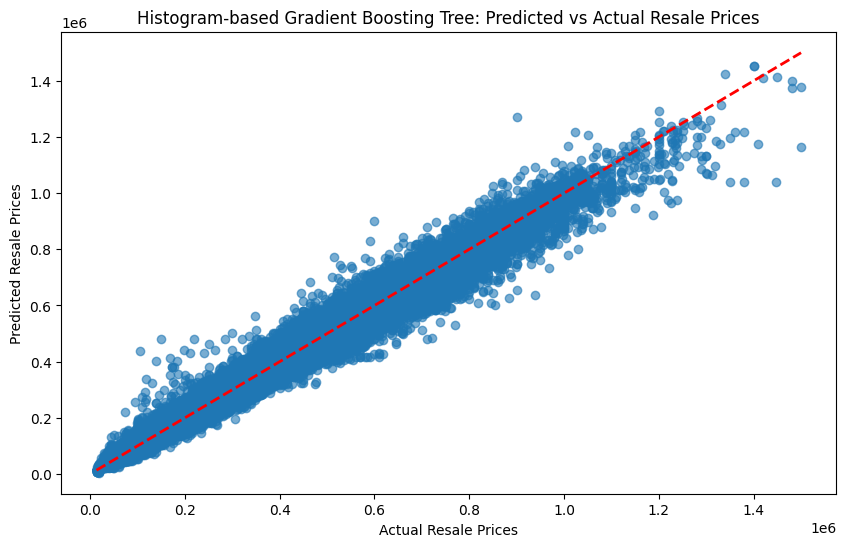

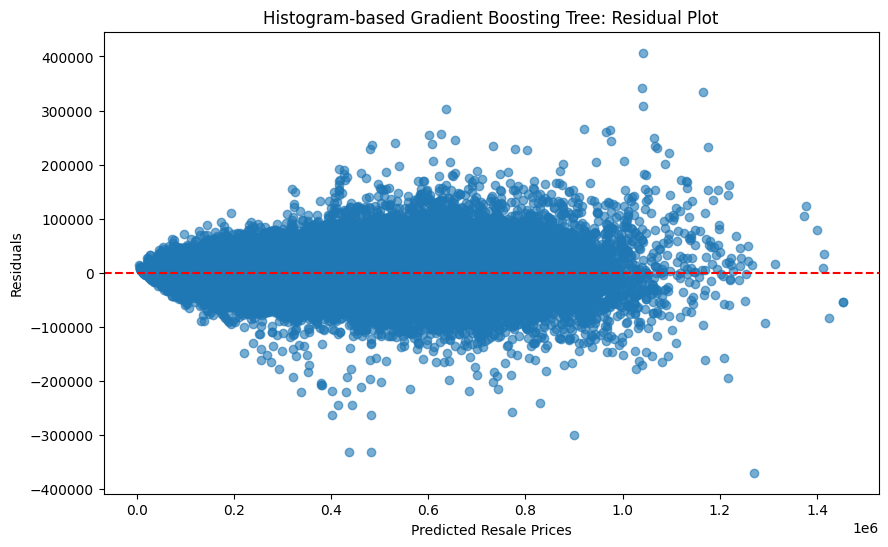

In [96]:
# 1. Plot: Predicted vs Actual Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, y_best_pred_actual, alpha=0.6)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
plt.xlabel('Actual Resale Prices')
plt.ylabel('Predicted Resale Prices')
plt.title('Histogram-based Gradient Boosting Tree: Predicted vs Actual Resale Prices')
plt.show()

# 2. Plot: Residual Plot (Actual - Predicted)
residuals = y_test_actual - y_best_pred_actual
plt.figure(figsize=(10, 6))
plt.scatter(y_best_pred_actual, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Resale Prices')
plt.ylabel('Residuals')
plt.title('Histogram-based Gradient Boosting Tree: Residual Plot')
plt.show()

In [131]:
# Load saved histgradientboosting model and scalers
model_path = "C:\\Users\\edson\\SIT\\PF-Project\\histgradientboosting_model.h5"
scaler_X_path = "C:\\Users\\edson\\SIT\\PF-Project\\scaler_X.pkl"
scaler_y_path = "C:\\Users\\edson\\SIT\\PF-Project\\scaler_y.pkl"

# Load the model and scalers
hgb_model = joblib.load(model_path)
scaler_X = joblib.load(scaler_X_path)
scaler_y = joblib.load(scaler_y_path)

# Load label encoders
label_encoders = joblib.load('label_encoders.pkl')

# Define input data for prediction
new_flat_values = {
    'month': 837,  
    'town': 'PUNGGOL',  
    'flat_type': '5 ROOM', 
    'block': '272A',  
    'street_name': 'PUNGGOL WALK',  
    'storey_range': 3,  
    'floor_area_sqm': 116.0,  
    'lease_commence_date': 2014,  
    'remaining_lease': 89,  
    'max_floor_lvl': 16,  
    'year_completed': 2012,  
    'nearest_mrt': 'punggol',  
    'nearest_distance_to_mrt': 0.221 
}

# Convert categorical values using the label encoders
for col in new_flat_values:
    if col in label_encoders:
        new_flat_values[col] = label_encoders[col].get(new_flat_values[col], -1) 

# Convert to a DataFrame
new_flat_df = pd.DataFrame([new_flat_values])

# Scale the input data
new_flat_scaled = scaler_X.transform(new_flat_df)

# Make the prediction
predicted_price_scaled = hgb_model.predict(new_flat_scaled)

# Convert the scaled prediction back to the original price range
predicted_price = scaler_y.inverse_transform(predicted_price_scaled.reshape(-1, 1))

print(f"The predicted resale price is: ${predicted_price[0][0]:,.2f}")

The predicted resale price is: $911,627.63


++++++++++++++++++++++++++++++++++  
### 3.3 Random Forest Regressor 
The reasons I used this model are:
- Robustness to outliers
  - Random Forest is less sensitive to outliers compared to other regression models as it uses the median rather than the mean to make predictions which helps in stabilizing predictions.
- High Predictive Accuracy
  - Often delivers strong performance for regression takss, making it a reliable choice for predicting complex outcomes like resale prices.
- Parallel Processing
  - Since each tree in the forest is build independently, Random Forest can take advantage of parallel processing, leading to faster training times on large datasets.

++++++++++++++++++++++++++++++++++  

In [98]:
# Define the model
rf_regressor = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 50], 
    'max_depth': [None, 5, 10], 
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1, 2] 
}

# Create a parameter grid manually
param_list = list(ParameterGrid(param_grid))

# Initialize variables to store the best model and lowest score
best_model = None
best_score = float('inf')

# Progress bar to track progress
with tqdm(total=len(param_list), desc="Training Progress") as pbar:
    for params in param_list:
        # Update the model with the current set of parameters
        rf_regressor.set_params(**params)
        
        # Train the model using ravel() to ensure y is 1D
        rf_regressor.fit(X_train, y_train.ravel())
        
        # Make predictions
        y_pred = rf_regressor.predict(X_test)
        
        # Calculate Mean Absolute Error (MAE) for this set of parameters
        mae = mean_absolute_error(y_test.ravel(), y_pred)
        
        # If this model has a lower MAE, update the best model and score
        if mae < best_score:
            best_score = mae
            best_model = rf_regressor
        
        # Update the progress bar
        pbar.update(1)

# Make predictions with the best model
y_best_pred = best_model.predict(X_test)

# Save the best model
model_filename = os.path.join("C:\\Users\\edson\\SIT\\PF-Project", 'randomforest_model.h5')
joblib.dump(best_model, model_filename)
print(f"Model saved as {model_filename}")

Training Progress: 100%|███████████████████████████████████████████████████████████████| 24/24 [16:52<00:00, 42.20s/it]


Model saved as C:\Users\edson\SIT\PF-Project\randomforest_model.h5


In [100]:
# Ensure that both y_test and predictions are inverse-transformed to their original scale
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_best_pred_actual = scaler_y.inverse_transform(y_best_pred.reshape(-1, 1)).ravel()

# Recalculate the metrics on the inverse-transformed data
mae_best = mean_absolute_error(y_test_actual, y_best_pred_actual)
mse_best = mean_squared_error(y_test_actual, y_best_pred_actual)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test_actual, y_best_pred_actual)
mape_best = np.mean(np.abs((y_test_actual - y_best_pred_actual) / np.clip(y_test_actual, 1e-7, None))) * 100
explained_variance_best = explained_variance_score(y_test_actual, y_best_pred_actual)

# Print model evaluation metrics
print(f"Best Random Forest Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae_best}")
print(f"Mean Squared Error (MSE): {mse_best}")
print(f"Root Mean Squared Error (RMSE): {rmse_best}")
print(f"R-squared: {r2_best}")
print(f"Adjusted R-squared: {1 - (1 - r2_best) * (len(y_test_actual) - 1) / (len(y_test_actual) - X_test.shape[1] - 1)}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_best:.2f}%")
print(f"Explained Variance Score: {explained_variance_best}")

Best Random Forest Model Evaluation Metrics:
Mean Absolute Error (MAE): 33198.48556102336
Mean Squared Error (MSE): 2374037645.067614
Root Mean Squared Error (RMSE): 48724.097170369554
R-squared: 0.9202388613557577
Adjusted R-squared: 0.9202331531228339
Mean Absolute Percentage Error (MAPE): 10.67%
Explained Variance Score: 0.9202505084872329


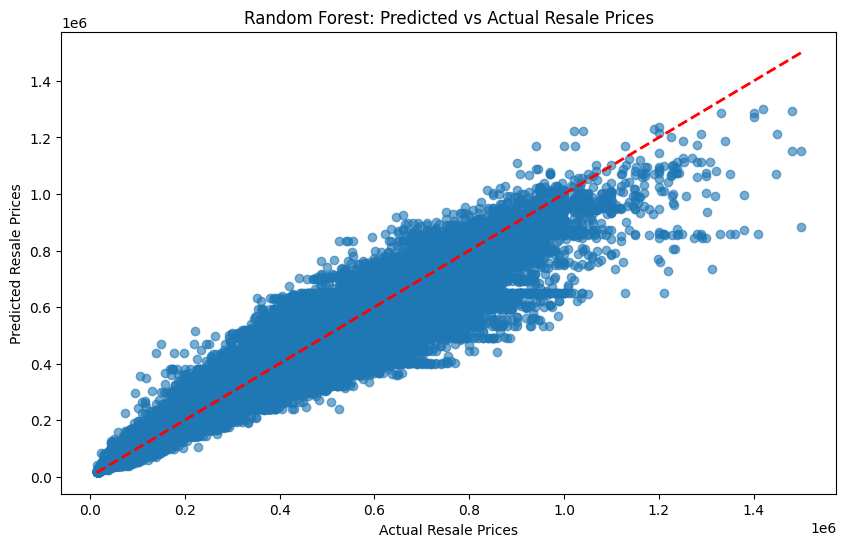

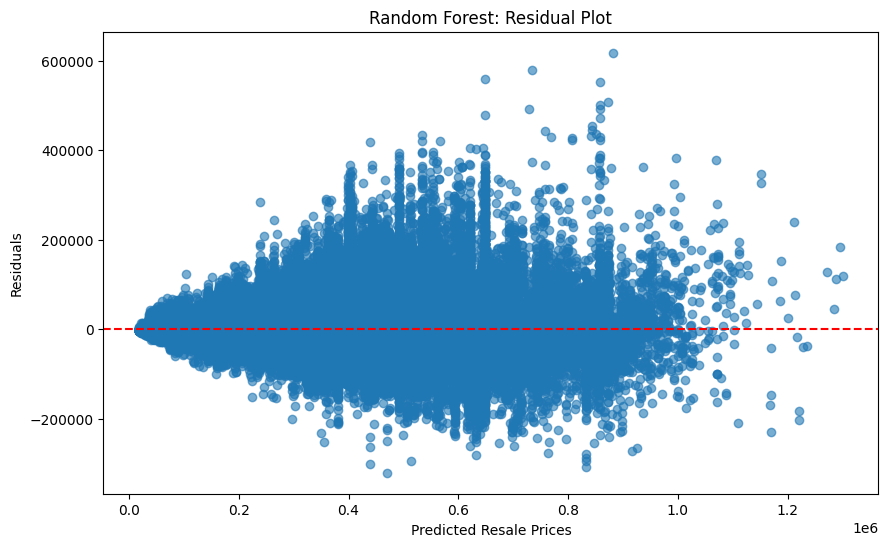

In [101]:
# 1. Plot: Predicted vs Actual Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, y_best_pred_actual, alpha=0.6)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
plt.xlabel('Actual Resale Prices')
plt.ylabel('Predicted Resale Prices')
plt.title('Random Forest: Predicted vs Actual Resale Prices')
plt.show()

# 2. Plot: Residual Plot (Actual - Predicted)
residuals = y_test_actual - y_best_pred_actual
plt.figure(figsize=(10, 6))
plt.scatter(y_best_pred_actual, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Resale Prices')
plt.ylabel('Residuals')
plt.title('Random Forest: Residual Plot')
plt.show()

In [132]:
# Load saved Random Forest model and scalers
model_path = "C:\\Users\\edson\\SIT\\PF-Project\\randomforest_model.h5"
scaler_X_path = "C:\\Users\\edson\\SIT\\PF-Project\\scaler_X.pkl"
scaler_y_path = "C:\\Users\\edson\\SIT\\PF-Project\\scaler_y.pkl"

# Load the model and scalers
rf_model = joblib.load(model_path)
scaler_X = joblib.load(scaler_X_path)
scaler_y = joblib.load(scaler_y_path)

# Load label encoders
label_encoders = joblib.load('label_encoders.pkl')

# Define input data for prediction
new_flat_values = {
    'month': 837,
    'town': 'PUNGGOL',
    'flat_type': '5 ROOM', 
    'block': '272A',  
    'street_name': 'PUNGGOL WALK', 
    'storey_range': 3, 
    'floor_area_sqm': 116.0,  
    'lease_commence_date': 2014,  
    'remaining_lease': 89, 
    'max_floor_lvl': 16,  
    'year_completed': 2012,  
    'nearest_mrt': 'punggol',  
    'nearest_distance_to_mrt': 0.221  
}

# Convert categorical values using the label encoders
for col in new_flat_values:
    if col in label_encoders:
        new_flat_values[col] = label_encoders[col].get(new_flat_values[col], -1)

# Convert to a DataFrame
new_flat_df = pd.DataFrame([new_flat_values])

# Scale the input data
new_flat_scaled = scaler_X.transform(new_flat_df)

# Make the prediction
predicted_price_scaled = rf_model.predict(new_flat_scaled)

# Convert the scaled prediction back to the original price range
predicted_price = scaler_y.inverse_transform(predicted_price_scaled.reshape(-1, 1))

print(f"The predicted resale price is: ${predicted_price[0][0]:,.2f}")

The predicted resale price is: $743,385.70


++++++++++++++++++++++++++++++++++  
### 3.4 XGBoost Regressor 
The reasons I chose this model are:
- Handling Non-Linearity:
  - Similar to other tree-based methods, XGBoost can effectively model complex non-linear relationships between features and target variables, which is crucial for predicting prices that can fluctuate due to various factors.
- Regularization:
  - XGBoost includes built-in L1 (Lasso) and L2 (Ridge) regularization techniques, helping to reduce overfitting and improve model generalization which is essential for accurate predictions on unseen data.

++++++++++++++++++++++++++++++++++  

In [103]:
# Define the model
xgb_regressor = XGBRegressor(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_child_weight': [1, 2, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

# Create a parameter grid manually
param_list = list(ParameterGrid(param_grid))

# Initialize variables to store the best model and lowest score
best_model = None
best_score = float('inf')

# Progress bar to track progress
with tqdm(total=len(param_list), desc="Training Progress") as pbar:
    for params in param_list:
        # Update the model with the current set of parameters
        xgb_regressor.set_params(**params)
        
        # Train the model using ravel() to ensure y is 1D
        xgb_regressor.fit(X_train, y_train.ravel())
        
        # Make predictions
        y_pred = xgb_regressor.predict(X_test)
        
        # Calculate Mean Absolute Error (MAE) for this set of parameters
        mae = mean_absolute_error(y_test.ravel(), y_pred)
        
        # If this model has a lower MAE, update the best model and score
        if mae < best_score:
            best_score = mae
            best_model = xgb_regressor
        
        # Update the progress bar
        pbar.update(1)

# Make predictions with the best model
y_best_pred = best_model.predict(X_test)

# Save the best model
model_filename = os.path.join("C:\\Users\\edson\\SIT\\PF-Project", 'xgboost_model.h5')
joblib.dump(best_model, model_filename)
print(f"Model saved as {model_filename}")

Training Progress: 100%|█████████████████████████████████████████████████████████████| 135/135 [30:34<00:00, 13.59s/it]


Model saved as C:\Users\edson\SIT\PF-Project\xgboost_model.h5


In [104]:
# Ensure that both y_test and predictions are inverse-transformed to their original scale
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel() 
y_best_pred_actual = scaler_y.inverse_transform(y_best_pred.reshape(-1, 1)).ravel()

# Recalculate the metrics on the inverse-transformed data
mae_best = mean_absolute_error(y_test_actual, y_best_pred_actual)
mse_best = mean_squared_error(y_test_actual, y_best_pred_actual)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test_actual, y_best_pred_actual)
mape_best = np.mean(np.abs((y_test_actual - y_best_pred_actual) / np.clip(y_test_actual, 1e-7, None))) * 100
explained_variance_best = explained_variance_score(y_test_actual, y_best_pred_actual)

# Print model evaluation metrics
print(f"Best XGBoost Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae_best}")
print(f"Mean Squared Error (MSE): {mse_best}")
print(f"Root Mean Squared Error (RMSE): {rmse_best}")
print(f"R-squared: {r2_best}")
print(f"Adjusted R-squared: {1 - (1 - r2_best) * (len(y_test_actual) - 1) / (len(y_test_actual) - X_test.shape[1] - 1)}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_best:.2f}%")
print(f"Explained Variance Score: {explained_variance_best}")

Best XGBoost Model Evaluation Metrics:
Mean Absolute Error (MAE): 17037.084383765585
Mean Squared Error (MSE): 696370148.4018412
Root Mean Squared Error (RMSE): 26388.82620356277
R-squared: 0.9766038773353954
Adjusted R-squared: 0.9766022029546136
Mean Absolute Percentage Error (MAPE): 5.78%
Explained Variance Score: 0.9766042922739806


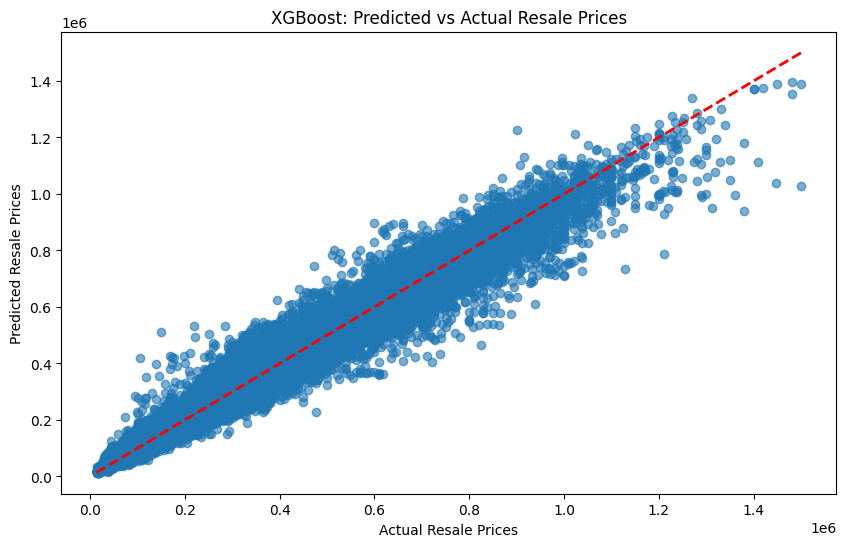

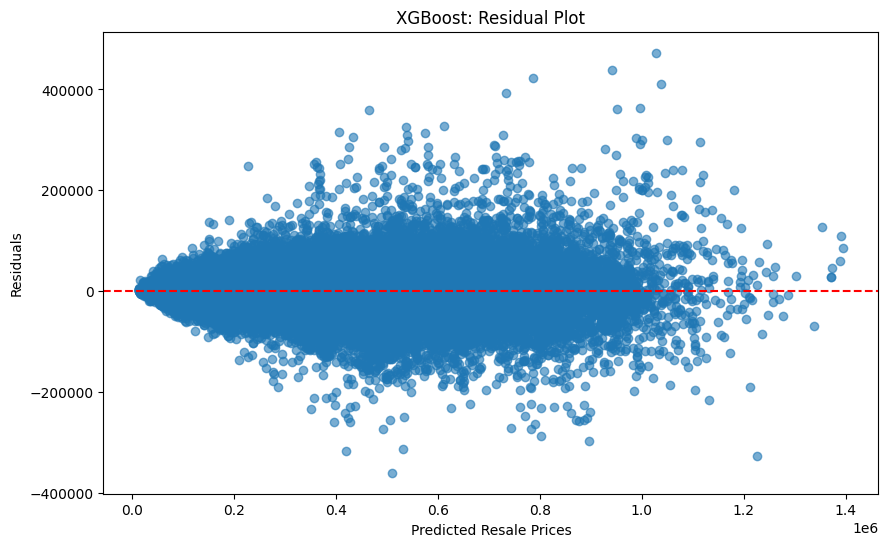

In [105]:
# 1. Plot: Predicted vs Actual Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, y_best_pred_actual, alpha=0.6)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
plt.xlabel('Actual Resale Prices')
plt.ylabel('Predicted Resale Prices')
plt.title('XGBoost: Predicted vs Actual Resale Prices')
plt.show()

# 2. Plot: Residual Plot (Actual - Predicted)
residuals = y_test_actual - y_best_pred_actual
plt.figure(figsize=(10, 6))
plt.scatter(y_best_pred_actual, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Resale Prices')
plt.ylabel('Residuals')
plt.title('XGBoost: Residual Plot')
plt.show()

In [133]:
# Load saved XGBoost model and scalers
model_path = "C:\\Users\\edson\\SIT\\PF-Project\\xgboost_model.h5"
scaler_X_path = "C:\\Users\\edson\\SIT\\PF-Project\\scaler_X.pkl"
scaler_y_path = "C:\\Users\\edson\\SIT\\PF-Project\\scaler_y.pkl"

# Load the model and scalers
xgb_model = joblib.load(model_path)
scaler_X = joblib.load(scaler_X_path)
scaler_y = joblib.load(scaler_y_path)

# Load label encoders
label_encoders = joblib.load('label_encoders.pkl')

# Define input data for prediction
new_flat_values = {
    'month': 837, 
    'town': 'PUNGGOL',  
    'flat_type': '5 ROOM', 
    'block': '272A',  
    'street_name': 'PUNGGOL WALK', 
    'storey_range': 3, 
    'floor_area_sqm': 116.0,  
    'lease_commence_date': 2014,  
    'remaining_lease': 89,  
    'max_floor_lvl': 16,  
    'year_completed': 2012,  
    'nearest_mrt': 'punggol',  
    'nearest_distance_to_mrt': 0.221  
}

# Convert categorical values using the label encoders
for col in new_flat_values:
    if col in label_encoders:
        new_flat_values[col] = label_encoders[col].get(new_flat_values[col], -1)

# Convert to a DataFrame
new_flat_df = pd.DataFrame([new_flat_values])

# Scale the input data
new_flat_scaled = scaler_X.transform(new_flat_df)

# Make the prediction
predicted_price_scaled = xgb_model.predict(new_flat_scaled)

# Convert the scaled prediction back to the original price range
predicted_price = scaler_y.inverse_transform(predicted_price_scaled.reshape(-1, 1))

# Print the predicted resale price
print(f"The predicted resale price is: ${predicted_price[0][0]:,.2f}")

The predicted resale price is: $914,165.94


++++++++++++++++++++++++++++++++++  
### 3.5 LSTM Model
The reasons I chose to use LSTM model are:
- Temporal Dependencies
  - LSTMs are designed to capture temporal dependencies and patterns in sequential data. Since the resale prices have time-related feature like remaining lease years, LSTM can effectively learn from these patterns over time.
- Complex Relationships
  - It can model complex non-linear relationships between input features and target variables. This is crucial for predicting prices influenced by various interdependent factors.
- Suitability for Time-Series Forecasting
  - My dataset includes historical price trends which LSTM is well-suited for capturing these characteristics.

++++++++++++++++++++++++++++++++++  

In [107]:
timesteps = 1
n_features = X_train.shape[1]

# Reshape the training data
X_train_reshaped = X_train.reshape((X_train.shape[0], timesteps, n_features))

# Reshape the test data similarly
X_test_reshaped = X_test.reshape((X_test.shape[0], timesteps, n_features))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()

# Flatten the target arrays
y_train_flat = y_train.ravel()
y_test_flat = y_test.ravel()

# Train the model with reshaped data and flattened targets
model.fit(X_train_reshaped, y_train_flat, epochs=20, batch_size=32)

# Make predictions with the reshaped test data
predictions = model.predict(X_test_reshaped)

# Save the model
model_filename = "C:\\Users\\edson\\SIT\\PF-Project\\lstm_model.h5"
model.save(model_filename)
print(f"LSTM model saved as {model_filename}")

# Make predictions with the reshaped test data
predictions = model.predict(X_test_reshaped)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 50)             12800     
                                                                 
 dropout_6 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 25)                1275      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 34,301
Trainable params: 34,301
Non-trai

In [108]:
# Ensure that both y_test and predictions are inverse-transformed to their original scale
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_best_pred_actual = scaler_y.inverse_transform(predictions.reshape(-1, 1)).ravel()

# Recalculate the metrics on the inverse-transformed data
mae_best = mean_absolute_error(y_test_actual, y_best_pred_actual)
mse_best = mean_squared_error(y_test_actual, y_best_pred_actual)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test_actual, y_best_pred_actual)
mape_best = mean_absolute_percentage_error(y_test_actual, y_best_pred_actual) * 100
explained_variance_best = explained_variance_score(y_test_actual, y_best_pred_actual)

# Calculate Adjusted R-squared
n = len(y_test_actual)
p = X_test.shape[1] 
adjusted_r2_best = 1 - (1 - r2_best) * (n - 1) / (n - p - 1)

# Print model evaluation metrics
print(f"Best LSTM Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae_best}")
print(f"Mean Squared Error (MSE): {mse_best}")
print(f"Root Mean Squared Error (RMSE): {rmse_best}")
print(f"R-squared: {r2_best}")
print(f"Adjusted R-squared: {adjusted_r2_best}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_best:.2f}%")
print(f"Explained Variance Score: {explained_variance_best}")

Best LSTM Model Evaluation Metrics:
Mean Absolute Error (MAE): 23080.892952490496
Mean Squared Error (MSE): 1074812222.3798385
Root Mean Squared Error (RMSE): 32784.328914587204
R-squared: 0.9638892639870827
Adjusted R-squared: 0.9638866796647458
Mean Absolute Percentage Error (MAPE): 8.38%
Explained Variance Score: 0.9643472171592448


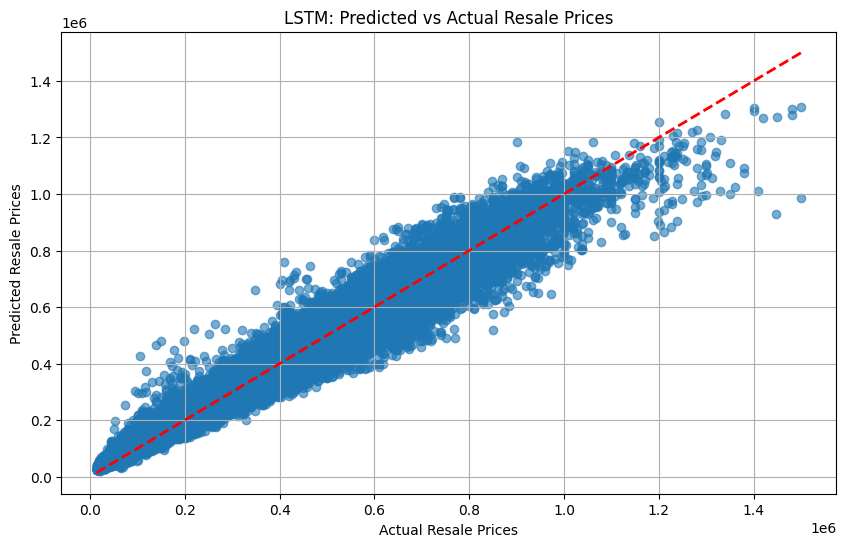

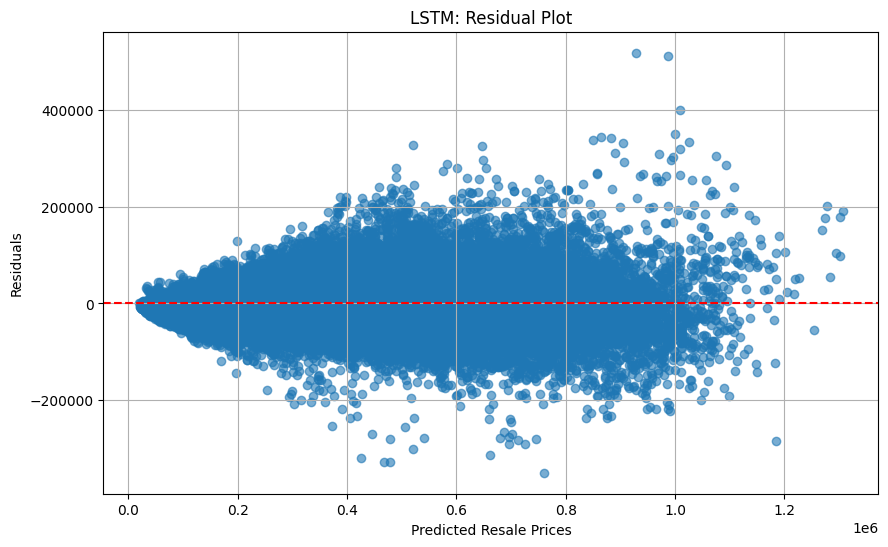

In [109]:
# 1. Plot: Predicted vs Actual Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, y_best_pred_actual, alpha=0.6)
plt.plot([y_test_actual.min(), y_test_actual.max()], 
         [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
plt.xlabel('Actual Resale Prices')
plt.ylabel('Predicted Resale Prices')
plt.title('LSTM: Predicted vs Actual Resale Prices')
plt.grid()
plt.show()

# 2. Plot: Residual Plot (Actual - Predicted)
residuals = y_test_actual - y_best_pred_actual
plt.figure(figsize=(10, 6))
plt.scatter(y_best_pred_actual, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Resale Prices')
plt.ylabel('Residuals')
plt.title('LSTM: Residual Plot')
plt.grid()
plt.show()

In [114]:
# Load the saved LSTM model and scalers
lstm_model_path = "C:\\Users\\edson\\SIT\\PF-Project\\lstm_model.h5"
scaler_X_path = "C:\\Users\\edson\\SIT\\PF-Project\\scaler_X.pkl"
scaler_y_path = "C:\\Users\\edson\\SIT\\PF-Project\\scaler_y.pkl"
label_encoders_path = 'label_encoders.pkl'

# Load the model and scalers
lstm_model = load_model(lstm_model_path)
scaler_X = joblib.load(scaler_X_path)
scaler_y = joblib.load(scaler_y_path)
label_encoders = joblib.load(label_encoders_path)

# Define input data for prediction
new_flat_values = {
    'month': 837,
    'town': 'PUNGGOL',
    'flat_type': '5 ROOM',
    'block': '272A',
    'street_name': 'PUNGGOL WALK',
    'storey_range': 3,
    'floor_area_sqm': 116.0,
    'lease_commence_date': 2014,
    'remaining_lease': 89,
    'max_floor_lvl': 16,
    'year_completed': 2012,
    'nearest_mrt': 'punggol',
    'nearest_distance_to_mrt': 0.221
}

# Convert categorical values using the label encoders
for col in new_flat_values:
    if col in label_encoders:
        # Ensure that label_encoders[col] is indeed a LabelEncoder instance
        if isinstance(label_encoders[col], dict):
            # Handle encoding using the dictionary mapping
            new_flat_values[col] = label_encoders[col].get(new_flat_values[col], -1)

# Convert to a DataFrame
new_flat_df = pd.DataFrame([new_flat_values])

# Scale the input data
new_flat_scaled = scaler_X.transform(new_flat_df)

# Reshape the input data for LSTM
timesteps = 1
n_features = new_flat_scaled.shape[1]
new_flat_scaled_reshaped = new_flat_scaled.reshape((1, timesteps, n_features))

# Make the prediction
predicted_price_scaled = lstm_model.predict(new_flat_scaled_reshaped)

# Convert the scaled prediction back to the original price range
predicted_price = scaler_y.inverse_transform(predicted_price_scaled.reshape(-1, 1))

# Print the predicted resale price
print(f"The predicted resale price is: ${predicted_price[0][0]:,.2f}")

1/1 [==============================] - 0s 247ms/step
The predicted resale price is: $923,292.25


++++++++++++++++++++++++++++++++++  
### 3.6 Neural Network Model
The reasons I chose to use Neural Network are:
- Versatility
  - Neural Networks can handle structured data, unstructured data and sequences.
- Advanced Techniques
  - Techniques like dropout, batch normalization and weight regularization can help prevent ovrfitting which allows neural network to generalize better to unseen data.
- Performance
  - NNs have achieved state-of-the-art results in various domains and can scale well with increasing amounts of data which often leads to improved performance with larger datasets.

++++++++++++++++++++++++++++++++++  

In [143]:
# Build the Neural Network model
model = Sequential()

# First Dense layer with increased neurons and dropout
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Second Dense layer with increased neurons and dropout
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Third Dense layer
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Output layer for predicting resale price
model.add(Dense(1))

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])

# Summary of the model
model.summary()

# Learning Rate Scheduler, Model Checkpointing, and Early Stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint(filepath='nn_model_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model with callbacks and increased epochs
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, 
                    callbacks=[lr_scheduler, checkpoint, early_stopping], verbose=1)

# Save the model after training
model_filename = 'C:\\Users\\edson\\SIT\\PF-Project\\nn_model.h5'
model.save(model_filename)
print(f"Model saved as {model_filename}")

# Make predictions on the test set
predictions = model.predict(X_test)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 256)               3584      
                                                                 
 batch_normalization_6 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_7 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_15 (Dropout)        (None, 128)              

In [144]:
# Ensure that both y_test and predictions are inverse-transformed to their original scale
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_best_pred_actual = scaler_y.inverse_transform(predictions.reshape(-1, 1)).ravel()

# Recalculate the metrics on the inverse-transformed data
mae_best = mean_absolute_error(y_test_actual, y_best_pred_actual)
mse_best = mean_squared_error(y_test_actual, y_best_pred_actual)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test_actual, y_best_pred_actual)
mape_best = mean_absolute_percentage_error(y_test_actual, y_best_pred_actual) * 100
explained_variance_best = explained_variance_score(y_test_actual, y_best_pred_actual)

# Calculate Adjusted R-squared
n = len(y_test_actual) 
p = X_test.shape[1]
adjusted_r2_best = 1 - (1 - r2_best) * (n - 1) / (n - p - 1)

# Print model evaluation metrics
print(f"Best Neural Network Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae_best}")
print(f"Mean Squared Error (MSE): {mse_best}")
print(f"Root Mean Squared Error (RMSE): {rmse_best}")
print(f"R-squared: {r2_best}")
print(f"Adjusted R-squared: {adjusted_r2_best}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_best:.2f}%")
print(f"Explained Variance Score: {explained_variance_best}")

Best Neural Network Model Evaluation Metrics:
Mean Absolute Error (MAE): 39765.623698037634
Mean Squared Error (MSE): 3858987824.9524436
Root Mean Squared Error (RMSE): 62120.751967055614
R-squared: 0.8703486174400118
Adjusted R-squared: 0.8703393387323213
Mean Absolute Percentage Error (MAPE): 12.19%
Explained Variance Score: 0.8717706559537314


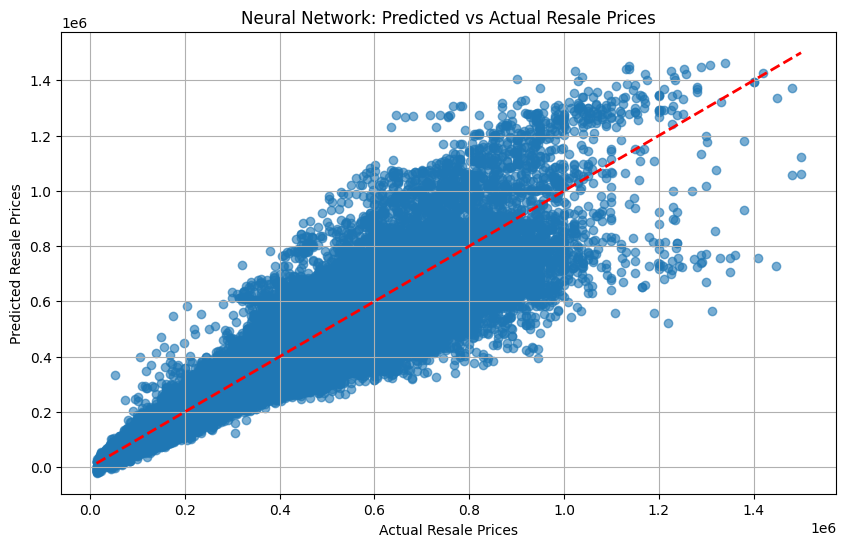

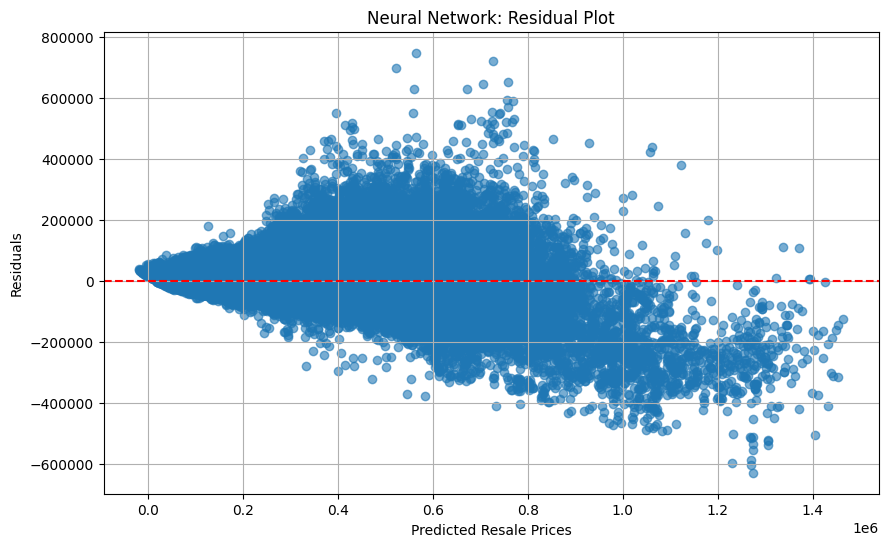

In [145]:
# 1. Plot: Predicted vs Actual Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, y_best_pred_actual, alpha=0.6)
plt.plot([y_test_actual.min(), y_test_actual.max()], 
         [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
plt.xlabel('Actual Resale Prices')
plt.ylabel('Predicted Resale Prices')
plt.title('Neural Network: Predicted vs Actual Resale Prices')
plt.grid()
plt.show()

# 2. Plot: Residual Plot (Actual - Predicted)
residuals = y_test_actual - y_best_pred_actual
plt.figure(figsize=(10, 6))
plt.scatter(y_best_pred_actual, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Resale Prices')
plt.ylabel('Residuals')
plt.title('Neural Network: Residual Plot')
plt.grid()
plt.show()

In [153]:
# Load the saved LSTM model and scalers
nn_model_path = "C:\\Users\\edson\\SIT\\PF-Project\\nn_model_best.h5"
scaler_X_path = "C:\\Users\\edson\\SIT\\PF-Project\\scaler_X.pkl"
scaler_y_path = "C:\\Users\\edson\\SIT\\PF-Project\\scaler_y.pkl"
label_encoders_path = 'label_encoders.pkl'

# Load the model and scalers
nn_model = load_model(nn_model_path)
scaler_X = joblib.load(scaler_X_path)
scaler_y = joblib.load(scaler_y_path)

# Load label encoders
label_encoders = joblib.load('label_encoders.pkl')

# Define input data for prediction
new_flat_values = {
    'month': 837,
    'town': 'PUNGGOL', 
    'flat_type': '5 ROOM', 
    'block': '272A', 
    'street_name': 'PUNGGOL WALK', 
    'storey_range': 3, 
    'floor_area_sqm': 116.0,  
    'lease_commence_date': 2014,  
    'remaining_lease': 89,  
    'max_floor_lvl': 16,  
    'year_completed': 2012, 
    'nearest_mrt': 'punggol',  
    'nearest_distance_to_mrt': 0.221  
}

# Convert categorical values using the label encoders
for col in new_flat_values:
    if col in label_encoders:
        new_flat_values[col] = label_encoders[col].get(new_flat_values[col], -1)

# Convert to a DataFrame
new_flat_df = pd.DataFrame([new_flat_values])

# Scale the input data
new_flat_scaled = scaler_X.transform(new_flat_df)

# Make the prediction
predicted_price_scaled = nn_model.predict(new_flat_scaled)

# Convert the scaled prediction back to the original price range
predicted_price = scaler_y.inverse_transform(predicted_price_scaled.reshape(-1, 1))

# Print the predicted resale price
print(f"The predicted resale price is: ${predicted_price[0][0]:,.2f}")

1/1 [==============================] - 0s 47ms/step
The predicted resale price is: $640,832.12


# ================= END =================